In [1]:
import pandas as pd
import numpy as np
import psycopg2
import config



In [2]:
password = config.password


In [3]:
connection = psycopg2.connect(
    user="postgres",
    password=password,
    host="127.0.0.1",
    port="5432",
    database="AIS_Project")

cursor = connection.cursor()

cursor.execute(f'''
WITH location_search as (
    SELECT * FROM "ais_raw_data"
    WHERE ("LAT" BETWEEN 37.2 AND 37.627) AND ("LON" BETWEEN -122.935 AND -121.3)),

    "convert_query" as (
    SELECT to_char("BaseDateTime", 'YYYY-mm') as "date", "MMSI", "VesselType"
    FROM "location_search"),
    
    "unique_search" as (
    SELECT DISTINCT("date", "MMSI", "VesselType") as "test", "date", "VesselType" FROM "convert_query"
    GROUP BY "test", "date", "VesselType")

SELECT "date", "VesselType", Count("VesselType") 
FROM unique_search
GROUP BY "date", "VesselType"
ORDER BY "date";
''')

record = cursor.fetchall()

data_df = pd.DataFrame(record, columns=["basedatetime", "vesseltype", "count"])
data_df = data_df.set_index("basedatetime")
data_df

,vesseltype,count
basedatetime,,
2018-01,37.0,49
2018-01,51.0,2
2018-01,82.0,1
2018-01,36.0,10
2018-01,71.0,1
...,...,...
2022-03,72.0,1
2022-03,50.0,1
2022-03,89.0,3


In [4]:
unique_dates = []
unique_vt = []
for x in data_df.index:
    if x not in unique_dates:
        unique_dates.append(x)
 
for x in data_df["vesseltype"]:
    if x not in unique_vt:
        unique_vt.append(x)


In [5]:
AIS_df = pd.DataFrame(columns=["Fishing", "TugTow", "Recreational", "Passenger", "Cargo", "Tanker", "Other", "Unavailable"], index=unique_dates)

In [6]:
AIS_df.head()

zero_data = np.zeros(shape=(len(AIS_df), len(AIS_df.columns)))

AIS_df = pd.DataFrame(zero_data, columns=["Fishing", "TugTow", "Recreational", "Passenger", "Cargo", "Tanker", "Other", "Unavailable"], index=unique_dates)


In [7]:
for index, row in enumerate(AIS_df.index):
    search_result = data_df.loc[row]
    for index, row in search_result.iterrows():
        if row[0] == 30:
            AIS_df.loc[index, "Fishing"] += row[1]
        elif (row[0] == 31) or (row[0] == 32) or (row[0] == 52):
            AIS_df.loc[index, "TugTow"] += row[1]
        elif (row[0] == 36) or (row[0] == 37):
            AIS_df.loc[index, "Recreational"] += row[1]
        elif (row[0] >=60) and (row[0] <= 69):
            AIS_df.loc[index, "Passenger"] += row[1]
        elif (row[0] >=70) and (row[0] <= 79):
            AIS_df.loc[index, "Cargo"] += row[1]
        elif (row[0] >=80) and (row[0] <= 89):
            AIS_df.loc[index, "Tanker"] += row[1]
        elif (row[0] == 0):
            AIS_df.loc[index, "Unavailable"] += row[1]
        else: AIS_df.loc[index, "Other"] += row[1]


In [8]:
AIS_df.reset_index(inplace=True)
AIS_df

,index,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable
0,2018-01,26.0,26.0,59.0,8.0,145.0,58.0,12.0,12.0
1,2018-02,23.0,29.0,70.0,8.0,142.0,45.0,12.0,16.0
2,2018-03,24.0,30.0,72.0,16.0,138.0,48.0,7.0,19.0
3,2018-04,23.0,23.0,89.0,14.0,148.0,56.0,14.0,16.0
4,2018-05,20.0,30.0,134.0,23.0,148.0,49.0,11.0,21.0
5,2018-06,27.0,28.0,135.0,14.0,155.0,52.0,21.0,26.0
6,2018-07,31.0,26.0,143.0,9.0,151.0,53.0,15.0,24.0
7,2018-08,35.0,26.0,153.0,11.0,144.0,57.0,17.0,32.0
8,2018-09,20.0,32.0,205.0,18.0,133.0,43.0,18.0,38.0
9,2018-10,21.0,31.0,148.0,22.0,138.0,52.0,23.0,36.0


<AxesSubplot:xlabel='index'>

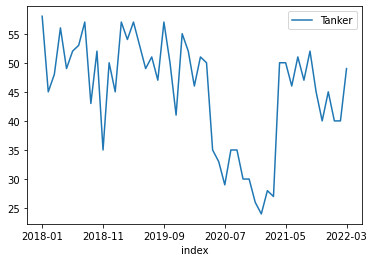

In [10]:
AIS_df.plot(x="index", y="Tanker")